# Import Libraries


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

In [ ]:
!pip install -qU gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import gdown 
import os
import tqdm
from pprint import pprint
from itertools import cycle

# This part to show what version you're using for each package.
print('Information [version]:')
print('tensorflow', tf.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('sklearn', sklearn.__version__)
print('imblearn', imblearn.__version__)
print('matplotlib', mpl.__version__)
print('seaborn', sns.__version__)
print('tqdm', tqdm.__version__)
print('gdown', gdown.__version__)
print('imblearn', imblearn.__version__)

%matplotlib inline

Information [version]:
tensorflow 2.3.0
numpy 1.18.5
pandas 1.1.4
sklearn 0.22.2.post1
imblearn 0.4.3
matplotlib 3.2.2
seaborn 0.11.0
tqdm 4.41.1
gdown 3.6.4
imblearn 0.4.3


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# General Configuration

In [ ]:
# GENERAL CONFIGURATION
RANDOM_SEED = 42
TEST_SIZE = 0.01
VAL_SIZE = 0.01
BATCH_SIZE = 128
EPOCHS = 10

# Load Dataset

This dataset presents the transactions that occurred in two days. The dataset has +200k rows and 31 columns. The time, amount, and class are non-transformed features. The V1 to V28 columns were transformed using a dimensional reduction PCA (Principle Component Analysis) to protect user identities.

In [ ]:
url = 'https://drive.google.com/uc?id=xxx'
output = 'creditcard.csv'
gdown.download(url, output, quiet=False)

In [ ]:
data = pd.read_csv('./creditcard.csv')
data['Class'] = data['Class'].apply(lambda x: int(x.replace("'", "")))
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Statistics

**Correlation**

The correlation matrix helps to see if there is any strong correlation between variables in the dataset and tell us whether or not we need to remove any of them. Also, we can determine the significant features of the overall classification. Most of the values are fairly unrelated to the others (close to zero). As an example, the correlation between (amount, V2), (amount, V4), and (time, V3) are (-0.53), (0.4), and (-0.42), respectively. But, they do not have strange behavior, and there is no need to pull out any columns






In [ ]:
# # Correlation matrix has correlation variable between -1 and +1. 
# # More close to -1, +1 shows more correlation. 
# # more close to zero and far away from -1 and +1 shows less correlation
#  corrmat = data.corr()
# fig = plt.figure(figsize=(12, 9))

# sns.heatmap(corrmat, vmax=0.8, square=True)
# plt.show()

**Numerical Summary**

In [ ]:
pd.set_option('precision', 3)
data.loc[:, ['Time', 'Amount']].describe()

,Time,Amount
count,284807.000,284807.000
mean,94813.860,88.350
std,47488.146,250.120
min,0.000,0.000
25%,54201.500,5.600
50%,84692.000,22.000
75%,139320.500,77.165
max,172792.000,25691.160


**Pairplot of Features**

![PairPlot](https://doc-10-34-docs.googleusercontent.com/docs/securesc/fkbibk97vkudhv15adtlumcgh2ok1gg4/5gefsnm1dbcqet3hjph30q36ikll3325/1576850400000/02591992915189960597/02591992915189960597/1q-gaSFy0kE_tP3qrypb1wMKAUCQOraPC?authuser=0&nonce=tj5qcn4806i1i&user=02591992915189960597&hash=aa44ivpr0fcjf689vcfsbv3su796ll7i)

In [ ]:
# url = 'https://drive.google.com/uc?id=xxx'
# output = 'pairplot.png'
# gdown.download(url, output, quiet=False)

In [ ]:
# Pair plot 
#sns.pairplot(data, hue='Class')

**Fraud/Non-Fraud Transactions**

In [ ]:
fraud = data[data['Class'] == 1]
nonfraud = data[data['Class'] == 0]
print(f'Fraudulent:{len(fraud)}, non-fraudulent:{len(nonfraud)}')
print(f'the positive class (frauds) percentage: {len(fraud)}/{len(fraud) + len(nonfraud)} ({len(fraud)/(len(fraud) + len(nonfraud))*100:.3f}%)')

Fraudulent:492, non-fraudulent:284315
the positive class (frauds) percentage: 492/284807 (0.173%)


Text(0.5, 0, '0:Non-Fraudulent, 1:Fraudulent')

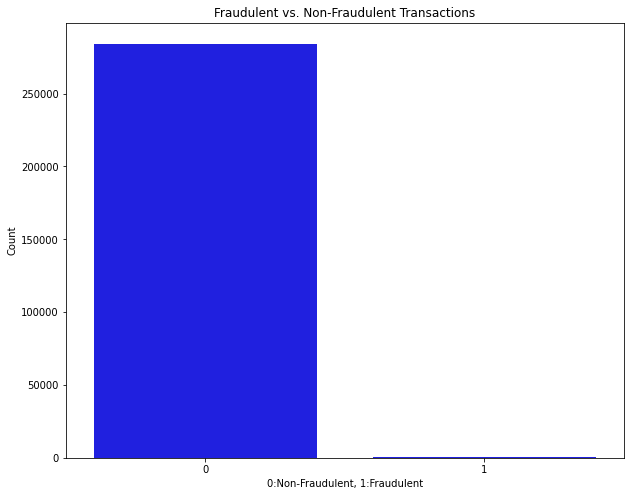

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(x=data['Class'].value_counts().index, y=data['Class'].value_counts(),color='blue')
plt.title('Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Count')
plt.xlabel('0:Non-Fraudulent, 1:Fraudulent')

**Unblanaced Dataset**

Imbalance data means that the number of data points available (Distribution) for different classes is significantly different. The CreditCard dataset is highly skewed data. It involves more data that are legitimated, and few of them (In this case, 0.173%) are not. But, the goal will be to capture as many of those disturbing fraudsters as possible.


# Preparation

This part considers to handling the imbalanced issue. There are several techniques to solve this problem. One of them is Over-sampling the minority class (fraud). Second, Under-sampling the majority class (standard).

In [ ]:
# Split up data to X (Drop the column Class), Y(Include only the column Class)
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

X = np.asarray(data.iloc[:, ~data.columns.isin(['Class'])])
Y = np.asarray(data.iloc[:, data.columns == 'Class'])

# # under sampling
rus = RandomUnderSampler(ratio='auto', random_state=RANDOM_SEED, replacement=False)
Xus, Yus = rus.fit_sample(X, Y.reshape(len(Y)))
Xus, Yus = np.asarray(Xus), np.asarray(Yus)
data_us = pd.DataFrame(np.hstack([Xus, np.expand_dims(Yus, -1)]))
data_us.columns = data.columns

# # over sampling
sm = SMOTE(ratio='minority', random_state=RANDOM_SEED, kind='borderline1')
Xos, Yos = sm.fit_sample(X, Y.reshape(len(Y)))
Xos, Yos = np.asarray(Xos), np.asarray(Yos)
data_os = pd.DataFrame(np.hstack([Xos, np.expand_dims(Yos, -1)]))
data_os.columns = data.columns

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
# Checking
print(len(data))
print(len(data_us))
print(len(data_os))

284807
984
568630



# Utils

For evaluating the performance, Accuracy, Recall, Precision, and F1 metrics have been chosen.

1. True Positive (TP): a fraudulent transaction class, the model predicts it as fraudulent.
2. True Negative (TN): a normal transaction class, the model predicts it as normal.
3. False positive (FP): a fraudulent transaction, the model predicts it as normal.
4. False Negative (FN): a normal transaction, the model predicts it as fraudulent

**Accuracy**

Accuracy is a ratio of correctly predicted observation of the total views. It has not a good performance on an Imbalanced dataset (more data are legitimate, and few of them are not [0.173%] ). Then we get high accuracy even though the classifier has not learned anything about the classification problem (fraud detection) at hand! 
But, when you have symmetric datasets, it is a good metric.
$$ACC = \frac{TP+TN}{TP+TN+FP+FN}$$


**Recall**

The recall is the ratio of correctly predicted (identified) positive observations out of the fraudulent transaction. 
$$Recall = \frac{TP}{TP+FN}$$

**Precision**

Precision is the ratio of correctly predicted positive observations of the total predicted transaction. (what percentage were fraudulent) 
$$Precision = \frac{TP}{TP+FP}$$

**F1 Score**

F1 score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.

$$F1 = 2 * \frac{Recall * Precision}{Recall+Precision}$$


F1 Score is usually more useful than accuracy, especially if you have an uneven class distribution (imbalanced data). Accuracy works best if false positives and false negatives have a similar cost. If the value of false positives and false negatives are very different, it’s better to look at both Precision and Recall. 


In [ ]:
def evaluation(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print('         Accuracy:', accuracy)
    print('  Precision Score:', precision)
    print('     Recall Score:', recall)
    print('         F1 Score:', f1)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    }

# Task 1 <small>(Supervised)</small>

**Neural Network (NN) intuition**

An artificial neuron often referred to as a node or perceptron, which can be interconnected with multiple perceptrons, much like synapses, to create a neural network.

**Architecture**

In the first part, the dataset was studied and standardized the Amount column of the transaction — also, under-sampling and over-sampling used on the dataset to handle the unbalanced data. Then split them to train and test sets.

The second part, built the three-layer perceptrons neural network with the following hyperparameters: the "relu" activation function for two inners unites and "softmax" for output unit. Adam and SparseCategoricalCrossentropy set for the optimizer and the loss part. The third part fit the model by the following config. 

Finally, evaluate and predict the model on the test set. The performance of the model for all metrics ( Accuracy, Recall, Precision, and F1 score) is 99% approximately. 



**Visualization**

The Precision/Recall (PR)  plot has a sensitivity (= recall) x-axis that identifies the number of minority classes. Moreover, the y-axis is a positive predictive value (= precision) that tells how sure it can be when we have a positive result (the class is a fraud). The perfect test result passes through the upper right corner (corresponding to 100 % precision and 100 % recall). 

The Receiver Operating Characteristic (ROC) is a probability curve, and Area Under The Curve (AUC) represents the degree or measure of separability. Higher AUC (near to the 1) means the model is better performance at predicting 0s as 0s and 1s as 1s. Two curves do not overlap at all means model has an ideal measure of separability. It is perfectly able to distinguish between positive class and negative class. The perfect test will have a ROC curve that passes through the upper left corner (corresponding to 100 % (TPR) and 100 % (FPR)).

In [ ]:
_data = data_os  
_X = np.asarray(_data.iloc[:, ~_data.columns.isin(['Class'])])
_Y = np.asarray(_data.iloc[:, _data.columns == 'Class'])

x_train, x_test, y_train, y_test = train_test_split(_X, _Y, test_size=0.01)

print('Train %s, Test %s' % (len(x_train), len(x_test)))

Train 562943, Test 5687


In [ ]:
x_train.shape

(562943, 29)

In [ ]:
def mlp_model(input_dim, output_dim, hidden_struct, lr, act='relu'): 
    # procedure
    #   inputs
    inputs = tf.keras.layers.Input(shape=[input_dim], name='inputs')
    #   hidden layers
    x = inputs
    for i, hidden in enumerate(hidden_struct):
        if len(hidden) == 2:
            units, act = hidden
        else:
            units, act = hidden[0], act

        x = tf.keras.layers.Dense(units, activation=act,  name='hidden_layer_%s' % i)(x)

    #   outputs [prediction/classifcation/labeling]
    outputs = tf.keras.layers.Dense(output_dim, activation='softmax', name='prediction')(x)


    # model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mlp')

    # compile
    opt = tf.keras.optimizers.Adam(lr=lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(name='loss')
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    ]
    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    return model

In [ ]:
hidden_struct = [
    (16, 'relu'),
    (8, 'relu')
]
model = mlp_model(x_train.shape[1], 2, hidden_struct=hidden_struct, lr=1e-3)
model.summary()

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 29)]              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 16)                480       
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 8)                 136       
_________________________________________________________________
prediction (Dense)           (None, 2)                 18        
Total params: 634
Trainable params: 634
Non-trainable params: 0
_________________________________________________________________


In [ ]:
r = model.fit(
    x_train, y_train,
    validation_split=0.01,
    batch_size=256,
    epochs=30,
    verbose=1
)

Epoch 1/30
2178/2178 [==============================] - 5s 2ms/step - loss: 0.0591 - accuracy: 0.9789 - val_loss: 0.0215 - val_accuracy: 0.9954
Epoch 2/30
2178/2178 [==============================] - 5s 2ms/step - loss: 0.0083 - accuracy: 0.9984 - val_loss: 0.0145 - val_accuracy: 0.9979
Epoch 3/30
2178/2178 [==============================] - 5s 2ms/step - loss: 0.0057 - accuracy: 0.9991 - val_loss: 0.0089 - val_accuracy: 0.9988
Epoch 4/30
2178/2178 [==============================] - 5s 2ms/step - loss: 0.0047 - accuracy: 0.9993 - val_loss: 0.0087 - val_accuracy: 0.9988
Epoch 5/30
2178/2178 [==============================] - 5s 2ms/step - loss: 0.0040 - accuracy: 0.9994 - val_loss: 0.0075 - val_accuracy: 0.9988
Epoch 6/30
2178/2178 [==============================] - 5s 2ms/step - loss: 0.0037 - accuracy: 0.9995 - val_loss: 0.0071 - val_accuracy: 0.9988
Epoch 7/30
2178/2178 [==============================] - 5s 2ms/step - loss: 0.0033 - accuracy: 0.9995 - val_loss: 0.0076 - val_accuracy:

['accuracy', 'loss']
['val_accuracy', 'val_loss']



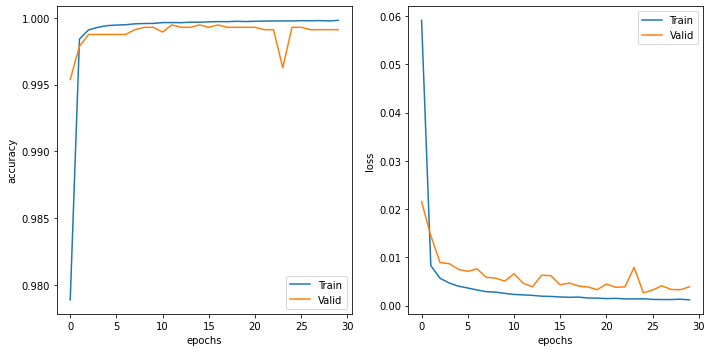

In [ ]:
# Loss/Accuracy

xs = sorted([item for item in r.history.keys() if 'val' not in item])
ys = sorted([item for item in r.history.keys() if 'val' in item])
epochs = list(range(len(r.history['accuracy'])))
print(xs)
print(ys)
print()

nrows = 1
ncols = round(len(xs) // nrows)

fig = plt.figure(figsize=(10, 5))
axes = []

for i, (x1, x2) in enumerate(zip(xs, ys)):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.plot(epochs, r.history[x1], label='Train')
    ax.plot(epochs, r.history[x2], label='Valid')
    ax.set_xlabel('epochs')
    ax.set_ylabel(x1.replace('_metric', ''))
    ax.legend()
    axes.append(ax)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation
ev = model.evaluate(x_test, y_test)
print()
print('Evaluation:')
print('===' * 15)
print(ev)
print()

y_pred_test = model.predict(x_test)
print('Prediction:')
print('===' * 15)
res_mlp = evaluation(y_test, y_pred_test.argmax(axis=-1))

178/178 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.9998

Evaluation:
[0.002913933014497161, 0.9998241662979126]

Prediction:
         Accuracy: 0.9998241603657464
  Precision Score: 0.9996516893068618
     Recall Score: 1.0
         F1 Score: 0.999825814318063


In [ ]:
# Precision/Recall Plot

def plot_precision_recall(y_true, y_pred_prob):

    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.70, 0.75, 0.8, 0.9, 0,95]
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue', 'black'])

    plt.figure(figsize=(5, 5))

    j = 1
    for i, color in zip(thresholds, colors):
        y_test_predictions_prob = y_pred_prob[:, 1] > i

        precision, recall, thresholds = precision_recall_curve(y_test, y_test_predictions_prob)

        # Plot Precision-Recall curve
        plt.plot(recall, precision, color=color, label='Threshold: %s' % i)
        plt.xlabel('RECALL')
        plt.ylabel('PRECISION')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall Plot')
        plt.legend(loc="lower left")
    plt.show()

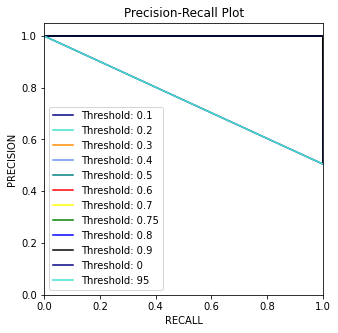

In [ ]:
plot_precision_recall(y_test, y_pred_test)

In [ ]:
# AUC/ROC Plot

def plot_auc_roc_curve(y_true, y_pred):

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([-0.1, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc

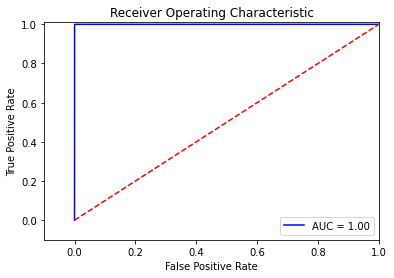

0.9998225062122826

In [ ]:
plot_auc_roc_curve(y_test, y_pred_test.argmax(axis=-1))

The Precision-Recall Plot is more informative than ROC when it is implemented on a binary imbalanced problem because ROC curves have a proper measurement when there are roughly equal numbers of observations for each class. Precision-Recall curves when there is a moderate to imbalance class.

# Task 2 <small>(Unsupervised)</small>

In this Task, IsolationForest, Kmeans, and Autoencoder were chosen. Among these algorithms, the Autoencoder showed better performance with a 26% F1 score.

## IsolationForest

IsolationForest is an efficient algorithm for outlier detection, especially in high-dimensional datasets. The algorithm builds a Random Forest in which each Decision Tree is grown randomly: at each node, and it picks a feature randomly, then it picks a random threshold value (between the min and max value) to split the dataset in two.

In [ ]:
_data = data
_X = np.asarray(_data.iloc[:, ~_data.columns.isin(['Class'])])
_Y = np.asarray(_data.iloc[:, _data.columns == 'Class'])

x_train, x_test, y_train, y_test = train_test_split(_X, _Y, test_size=0.1)
n_x_train = x_train[np.where(y_train == 0)[0], :]

print('Train %s, Test %s' % (len(x_train), len(x_test)))

Train 256326, Test 28481


In [ ]:
%%time

isolation_forest = IsolationForest(random_state=RANDOM_SEED)
isolation_forest.fit(n_x_train)

CPU times: user 5.85 s, sys: 26.4 ms, total: 5.87 s
Wall time: 5.87 s


In [ ]:
y_pred_test = isolation_forest.predict(x_test)
y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1

In [ ]:
isof_res = evaluation(y_test, y_pred_test)

         Accuracy: 0.9664688739861662
  Precision Score: 0.05321285140562249
     Recall Score: 0.8153846153846154
         F1 Score: 0.0999057492931197


## Kmeans

The Cluster is a collection of data objects that Similar to one another. kmeans is an algorithm that partitions or clusters N data points into K. 

**K-means** is,
* Partitional Clustering Approach
* K points are used to represent clustering result
* Each point corresponds to the center (Mean) of a cluster
* The number K, must be specified


In [ ]:
_data = data
_X = np.asarray(_data.iloc[:, ~_data.columns.isin(['Class'])])
_Y = np.asarray(_data.iloc[:, _data.columns == 'Class'])

_Xscaled = scale(_X)
# pca = PCA(n_components=2)
# _Xreducted = pca.fit_transform(_Xscaled)

x_train, x_test, y_train, y_test = train_test_split(_Xscaled, _Y, test_size=0.1)
n_x_train = x_train[np.where(y_train == 0)[0], :]

In [ ]:
%%time 

n_clusters = len(np.unique(y_train))
kmeans = KMeans(init='k-means++', n_clusters=n_clusters)
kmeans.fit(n_x_train)

CPU times: user 7.63 s, sys: 1.09 s, total: 8.72 s
Wall time: 7.33 s


In [ ]:
y_pred_test = kmeans.predict(x_test)

In [ ]:
kmeans_res = evaluation(y_test, y_pred_test)

         Accuracy: 0.47607176714300764
  Precision Score: 0.001341111781667002
     Recall Score: 0.40816326530612246
         F1 Score: 0.0026734393797620644


## Autoencoder

An autoencoder is a neural network that learns by encoding its input data to a lower or higher dimension in a hidden layer and tries to decode back to the original input. This process is called reconstruction.

In [ ]:
_data = data
_X = np.asarray(_data.iloc[:, ~_data.columns.isin(['Class'])])
_Y = np.asarray(_data.iloc[:, _data.columns == 'Class'])


x_train, x_test, y_train, y_test = train_test_split(_X, _Y, test_size=0.1)

n_x_train = x_train[np.where(y_train == 0)[0], :]

print(x_train.shape, n_x_train.shape, y_train.shape)
print(_Y.shape)

(256326, 30) (255889, 30) (256326, 1)
(284807, 1)


In [ ]:
n_x_train.shape[1]

30

In [ ]:
 def ae_model(input_dim, encoder_struct, decoder_struct, lr, act="relu"):
    #  inputs
    inputs = tf.keras.layers.Input(shape=[input_dim], name='inputs')
    #  hidden layers
    x = inputs
    for i, hidden in enumerate(encoder_struct):
        if len(encoder_struct) == 2:
            units, act = hidden
        else:
            units, act = hidden[0], act
        x = tf.keras.layers.Dense(units, activation=act, name='encoder_layers_%s' %i)(x)

    for i, hidden in enumerate(decoder_struct):
        if len(decoder_struct) == 2:
            units, act = hidden
        else:
            units, act = hidden[0], act
        x = tf.keras.layers.Dense(units, activation=act, name='decoder_layers_%s' %i)(x)   
    #  outputs
    outputs = tf.keras.layers.Dense(input_dim, activation='linear', name='rec_inputs')(x)
    # model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='ae')
    # compile
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.MeanSquaredError(name='loss')
    model.compile(optimizer=opt, loss=loss)

    return model

In [ ]:
encoder_struct = [
    (16, 'tanh'),
    (8, 'relu'),
]

decoder_struct = [
    (8, 'tanh'),
    (16, 'relu'),

]

model = ae_model(n_x_train.shape[1], encoder_struct, decoder_struct, lr=1e-3)
model.summary()

Model: "ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 30)]              0         
_________________________________________________________________
encoder_layers_0 (Dense)     (None, 16)                496       
_________________________________________________________________
encoder_layers_1 (Dense)     (None, 8)                 136       
_________________________________________________________________
decoder_layers_0 (Dense)     (None, 8)                 72        
_________________________________________________________________
decoder_layers_1 (Dense)     (None, 16)                144       
_________________________________________________________________
rec_inputs (Dense)           (None, 30)                510       
Total params: 1,358
Trainable params: 1,358
Non-trainable params: 0
______________________________________________________________

In [ ]:
r = model.fit(
    n_x_train, n_x_train,
    validation_split=0.01,
    batch_size=256,
    epochs=30,
    verbose=1
)

Epoch 1/30
990/990 [==============================] - 2s 2ms/step - loss: 374548352.0000 - val_loss: 375587904.0000
Epoch 2/30
990/990 [==============================] - 2s 2ms/step - loss: 372388608.0000 - val_loss: 372454240.0000
Epoch 3/30
990/990 [==============================] - 2s 2ms/step - loss: 368357280.0000 - val_loss: 367603424.0000
Epoch 4/30
990/990 [==============================] - 2s 2ms/step - loss: 362878208.0000 - val_loss: 361451232.0000
Epoch 5/30
990/990 [==============================] - 2s 2ms/step - loss: 355987840.0000 - val_loss: 353803136.0000
Epoch 6/30
990/990 [==============================] - 2s 2ms/step - loss: 347811872.0000 - val_loss: 345061120.0000
Epoch 7/30
990/990 [==============================] - 2s 2ms/step - loss: 338614976.0000 - val_loss: 335345216.0000
Epoch 8/30
990/990 [==============================] - 2s 2ms/step - loss: 328489760.0000 - val_loss: 324739264.0000
Epoch 9/30
990/990 [==============================] - 2s 2ms/step - loss

['loss']
['val_loss']



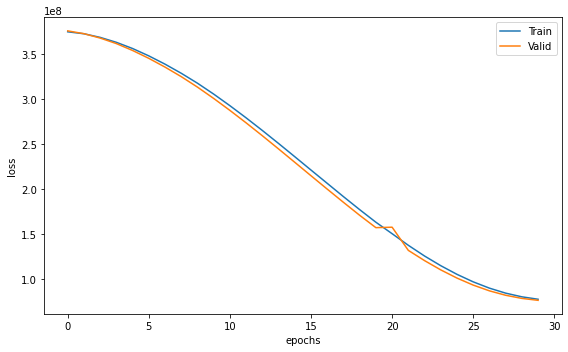

In [ ]:
# Loss/Accuracy

xs = sorted([item for item in r.history.keys() if 'val' not in item])
ys = sorted([item for item in r.history.keys() if 'val' in item])
epochs = list(range(len(r.history['loss'])))
print(xs)
print(ys)
print()

nrows = 1
ncols = round(len(xs) // nrows)

fig = plt.figure(figsize=(8, 5))
axes = []

for i, (x1, x2) in enumerate(zip(xs, ys)):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.plot(epochs, r.history[x1], label='Train')
    ax.plot(epochs, r.history[x2], label='Valid')
    ax.set_xlabel('epochs')
    ax.set_ylabel(x1.replace('_metric', ''))
    ax.legend()
    axes.append(ax)

plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(x_test)
rmse = np.mean(np.power(x_test - predictions, 2), axis=1)
y_pred_test = np.asarray([1 if p > 2 else 0 for p in rmse])

print(y_pred_test.shape)

(28481,)


In [ ]:
ae_res = evaluation(y_test, y_pred_test)

         Accuracy: 0.0019311119693830976
  Precision Score: 0.0019311119693830976
     Recall Score: 1.0
         F1 Score: 0.0038547799271096165


In [ ]:
# AUC/ROC Plot

def plot_auc_roc_curve(y_true, y_pred):

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([-0.1, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc

In [ ]:
plot_auc_roc_curve(y_test, y_pred_test.argmax(axis=-1))

# Comparison



In [ ]:
results = [
    res_mlp,
    isof_res,
    kmeans_res,
    ae_res
]
results = pd.DataFrame(results)
results = results.round(3)
results.index = ['ANN', 'ISOF', 'KMEANS', 'AE']
results

,Accuracy,Precision,Recall,F1
ANN,0.999,0.999,1.000,0.999
ISOF,0.903,0.016,0.885,0.032
KMEANS,0.150,0.003,0.984,0.005
AE,0.993,0.157,0.771,0.261


According to the above results, the supervised model (ANN) ranked first in terms of chosen metric (F1 score), and among unsupervised models, the Autoencode, IsolationForest, and Kmeans are placed second, third, and fourth, respectively.


The supervised model uses the transaction labels to train a classifier that can discriminate between normal and fraud transactions. The unsupervised model uses unlabeled data for training to capture the fraud transaction. As a result, the supervised learning model is highly accurate and time-saving. But in real-world problem, the insufficient annotation and data imbalance issue is going to be a critical matter. In that case, the unsupervised learning acts useful and finds all kinds of unknown patterns in data.